Copyright **`(c)`** 2021 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see 'LICENCE.md' for details.

In [1]:
import logging
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm

logging.basicConfig(
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

In [2]:
def rastrigin(x, A=10):
    """NumPy Rastrigin test function"""
    if x.ndim == 1:
        return -np.sum(A - A * np.cos(2 * np.pi * x) + x**2)
    else:
        return -np.sum(A - A * np.cos(2 * np.pi * x) + x**2, axis=1)

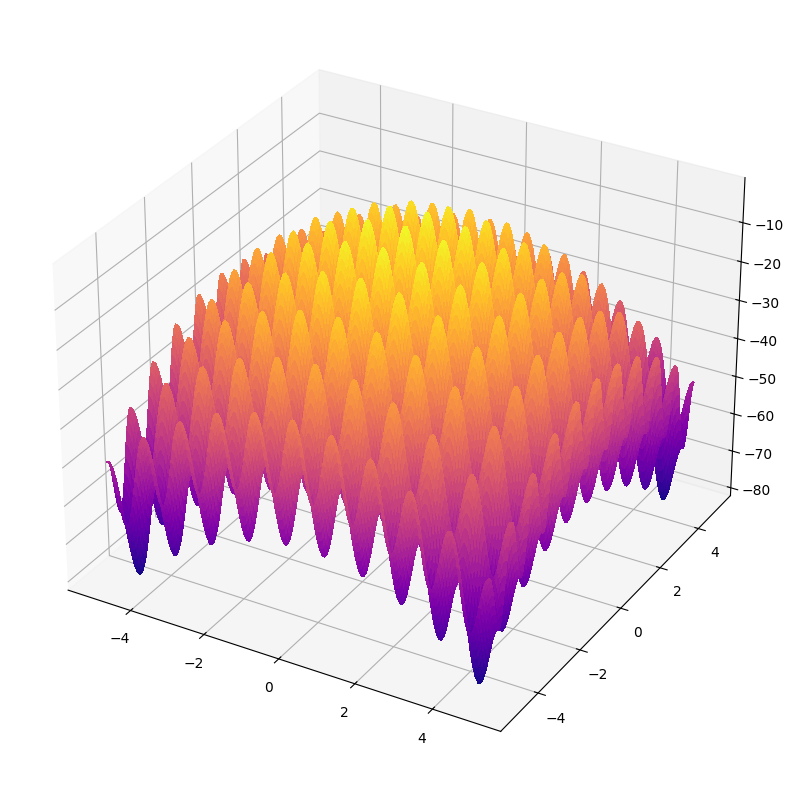

In [3]:
N_POINTS = 200
r = np.linspace(-5, 5, N_POINTS)

# yeuch, that's quite terrible...
x = np.array(np.meshgrid(r, r)).T.reshape(-1, 2)
z = rastrigin(x).reshape(N_POINTS, N_POINTS)
plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(
    *np.meshgrid(r, r),
    z,
    rstride=1,
    cstride=1,
    cmap=cm.plasma,
    linewidth=0,
    antialiased=False,
)
None

In [4]:
np.random.seed(42)
N_DIM = 4

## Vanilla (1+λ)-ES

[16:50:12] INFO: Best solution: -30.843473087556177


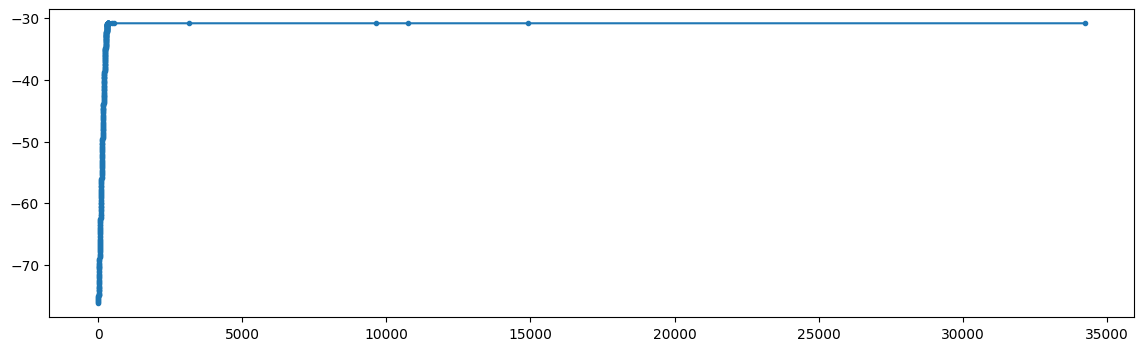

In [22]:
λ = 20
σ = 0.001

solution = np.random.random(N_DIM) * 5.12 * 2 - 5.12
history = list()
best_so_far = np.copy(solution)

for n in range(1_000_000 // λ):
    # offspring <- select λ random points mutating the current solution addictioning values from a normal distribution
    offspring = (
        np.random.normal(loc=0, scale=σ, size=(λ, N_DIM)) + solution
    )
    # evaluate and select best one
    evals = rastrigin(offspring)    #evalute using the rastrigin function (you don't need to know how it works inside)
    solution = offspring[np.argmax(evals)]  #take the elements using as indices the ones taken from the best elements in evals
    if rastrigin(best_so_far) < rastrigin(solution):
        best_so_far = np.copy(solution)
        history.append((n, rastrigin(solution)))

logging.info(f"Best solution: {rastrigin(best_so_far)}")

history = np.array(history)     #vector with all the best_solution gathered along the computation
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")

## Adaptive (1+λ)-ES

[19:36:52] INFO: Best solution: -1.6118733013900044 (current σ=2.23e+07)


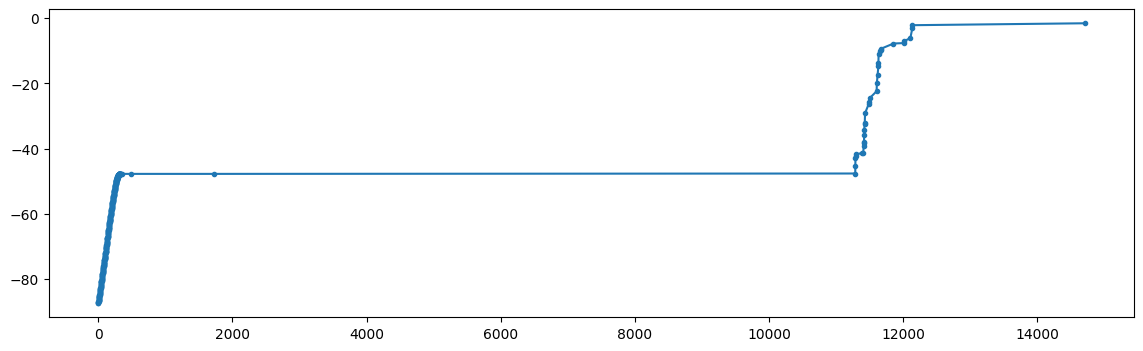

In [9]:
λ = 20
σ = 0.001

solution = np.random.random(N_DIM) * 5.12 * 2 - 5.12
history = list()
best_so_far = np.copy(solution)

stats = [0, 0]
for step in (range(1_000_000 // λ)):
    samples = (
        np.random.normal(loc=0, scale=σ, size=(λ, N_DIM)) + solution
    )
    evals = rastrigin(samples)
    stats[0] += λ       #total number of evaluated samples
    stats[1] += sum(evals > rastrigin(solution))    #total number of samples that have enhanched the solution
    solution = samples[np.argmax(evals)]

    if rastrigin(best_so_far) < rastrigin(solution):
        best_so_far = np.copy(solution)
        history.append((step, rastrigin(solution)))

#every 200 steps mutate sigma and re-initialize stats
    if (step + 1) % 200 == 0:  
        if stats[0] / stats[1] < 1 / 5:
            σ /= 1.1
        elif stats[0] / stats[1] > 1 / 5:
            σ *= 1.1
        stats = [0, 0]

logging.info(
    f"Best solution: {rastrigin(best_so_far)} (current σ={σ:0.3g})"
)

history = np.array(history)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")

## Adaptive (μ+λ)-ES

[19:46:34] INFO: Best solution: -2.984877212467328 (with σ=1e-05)


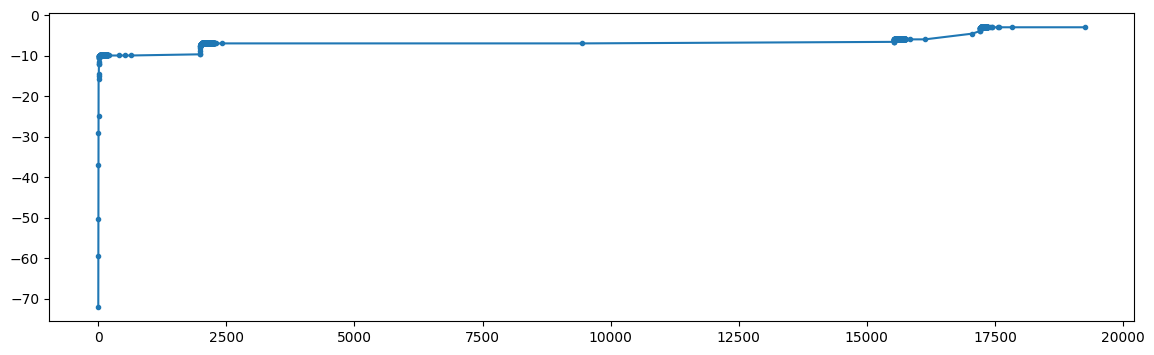

In [10]:
μ = 5       #number of individuals in the population
λ = 50      #number of generated solutions for each step
σ = 1

# initializes a random population of μ individuals, each with N_DIM size
population = np.random.random((μ, N_DIM + 1))
population[:, :-1] = population[:, :-1] * 5.12 * 2 - 5.12  #just initialization for Rastigin
population[:, -1] *= σ  #set the last element to sigma, it's a useful operation we'll exploit later for self-adaptation

best_fitness = None
history = list()
for step in (range(1_000_000 // λ)):
    # offspring <- select λ random points from the population of μ
    offspring = population[np.random.randint(0, μ, size=(λ,))] 
    # mutate all σ (last column) usign the current sigma value (loc=offspring[:, -1]) as avg of the distribution and scale=0.2 as std 
    offspring[:, -1] = np.random.normal(
        loc=offspring[:, -1], scale=0.2
    )

    # replace negative values with a small number
    offspring[offspring[:, -1] < 1e-5, -1] = 1e-5
    # mutate all v (all columns but the last), using the σ in the last column
    offspring[:, 0:-1] = np.random.normal(
        loc=offspring[:, 0:-1], scale=offspring[:, -1].reshape(-1, 1)
    )

    # add an extra column with the evaluation and sort
    #Offspring[fitness.argsort()] sorts the population of children by fitness. 
    fitness = rastrigin(offspring[:, 0:-1])
     # argsort() returns the indexes that would sort the fitness array, and Offspring[...] selects the individuals in this order.
    # So after this row, the first individual in Offspring will have the lowest fitness and the last individual will have the highest fitness
    offspring = offspring[fitness.argsort()]

    # save best (just for the plot)
    if best_fitness is None or best_fitness < np.max(fitness):
        best_fitness = np.max(fitness)
        history.append((step, best_fitness))

    # select the μ with max fitness and discard fitness 
    population = np.copy(offspring[-μ:])    #it takes the last μ individuals (PARENT SELECTION) so the best ones

fitness = rastrigin(population[:, 0:-1])
logging.info(
    f"Best solution: {fitness.max()} (with σ={population[fitness.argmax(), -1]:0.3g})"
)

history = np.array(history)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")